# Simulation

In this tutorial, you are going to simulate the spread of COVID-19 for an artificial
data set. First, some imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate


N_INDIVIDUALS = 10_000
N_INFECTIOUS = 100
N_PERIODS = 200

At first, we are loading some pre-defined parameters.

In [2]:
params = pd.read_csv(
    "../../../sid/params.csv", 
    index_col=["category", "subcategory", "name"])

Next, simulate some data on individuals which have two characteristics, an age group and
a country they live in.

In [3]:
age_group = np.random.choice(
    [
        "0 - 9",
        "10 - 19",
        "20 - 29",
        "30 - 39",
        "40 - 49",
        "50 - 59",
        "60 - 69",
        "70 - 79",
        "80 - 100",
    ],
    size=N_INDIVIDUALS,
)
region = np.random.choice(["Drenthe", "Gelderland", "Overtjssel"], size=N_INDIVIDUALS)

initial_states = pd.DataFrame({
    "age_group": age_group, 
    "region": region})
initial_states.head(5)

,age_group,region
0,10 - 19,Gelderland
1,40 - 49,Overtjssel
2,50 - 59,Drenthe
3,0 - 9,Gelderland
4,10 - 19,Gelderland


For the simulation, we need at least one individual which is infected.

In [4]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(
    N_INFECTIOUS, random_state=0).index
initial_infections.loc[infected_individuals] = True

Furthermore, we need to define how many contacts people have. We assume people have two
types of contacts, close and distant contacts. They also have fewer close than distant
contacts.

In [5]:
def meet_distant(states, params, period):
    contacts = np.random.choice(10, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, period):
    contacts = np.random.choice(5, size=len(states))
    return pd.Series(contacts, index=states.index)

assort_by=["age_group", "region"]

contact_models = {
    "meet_distant": {
        "contact_type": "distant", 
        "model": meet_distant, 
        "assort_by": assort_by,
    },
    "meet_close": {
        "contact_type": "close",
        "model": meet_close,
        "assort_by": assort_by,
    },
}

In [6]:
params.tail()

value  \
category         subcategory        name            
countdown_length cd_needs_icu_true  NaN   10.0000   
                 cd_dead            NaN    2.0000   
                 cd_needs_icu_false NaN   20.0000   
                 cd_knows_true      NaN    5.0000   
health_system    icu_limit_relative NaN    0.0005   

                                                                                       note  \
category         subcategory        name                                                      
countdown_length cd_needs_icu_true  NaN                                                 NaN   
                 cd_dead            NaN                                                 NaN   
                 cd_needs_icu_false NaN                                                 NaN   
                 cd_knows_true      NaN   This is the testing lag. It might vary by regi...   
health_system    icu_limit_relative NaN      Number of ICU beds relative to population size   

                                                                                     source  
category         subcategory        name                                                     
countdown_length cd_needs_icu_true  NaN   https://www.rki.de/DE/Content/InfAZ/N/Neuartig...  
                 cd_dead            NaN   https://www.rki.de/DE/Content/InfAZ/N/Neuartig...  
                 cd_needs_icu_false NaN   https://www.rki.de/DE/Content/InfAZ/N/Neuartig...  
                 cd_knows_true      NaN                                                 NaN  
health_system    icu_limit_relative NaN   https://www.dkgev.de/dkg/coronavirus-fakten-un...

Sid allows to estimate one infection probability per contact type. In this example,
close contacts are more infectious as distant contacts with 5% versus 3%. At last,
drop a generic infection rate.

In [7]:
to_add = [
    ("infection_prob", "meet_close", None), 
    ("infection_prob", "meet_distant", None)
]

infection_probs = pd.DataFrame(
    columns=params.columns, 
    index=pd.MultiIndex.from_tuples(to_add),
)
infection_probs["value"] = [0.05, 0.03]
params = params.append(infection_probs)

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

In [8]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1

contact_policies = {
    "meet_close": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "meet_distant": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

We are going to simulate this population for 200 periods.

In [9]:
df = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": N_PERIODS},
    contact_policies=contact_policies,
    seed=0,
)
df.head(5)

/home/klara/Dropbox/Projects/covid/sid/sid/pathogenesis.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  probs = params.loc["prob_icu_given_symptoms", "value"]
/home/klara/Dropbox/Projects/covid/sid/sid/pathogenesis.py:56: PerformanceWarning: indexing past lexsort depth may impact performance.
  probs = params.loc["prob_dead_given_icu", "value"]


age_group      region  ever_infected  immune  infectious  knows  \
date       id                                                                   
2020-02-27 0    10 - 19  Gelderland          False   False       False  False   
           1    40 - 49  Overtjssel          False   False       False  False   
           2    50 - 59     Drenthe          False   False       False  False   
           3      0 - 9  Gelderland          False   False       False  False   
           4    10 - 19  Gelderland          False   False       False  False   

               symptoms  needs_icu   dead  cd_infectious_true  ...  \
date       id                                                  ...   
2020-02-27 0      False      False  False                -3.0  ...   
           1      False      False  False                -3.0  ...   
           2      False      False  False                -3.0  ...   
           3      False      False  False                -3.0  ...   
           4      False      False  False                -3.0  ...   

               cd_needs_icu_false_draws  cd_knows_true_draws  \
date       id                                                  
2020-02-27 0                       20.0                  5.0   
           1                       20.0                  5.0   
           2                       20.0                  5.0   
           3                       20.0                  5.0   
           4                       20.0                  5.0   

               cd_infectious_true_draws  cd_infectious_false_draws  period  \
date       id                                                                
2020-02-27 0                        3.0                        8.0       0   
           1                        3.0                        8.0       0   
           2                        3.0                        8.0       0   
           3                        3.0                        8.0       0   
           4                        3.0                        8.0       0   

               missed_meet_close  missed_meet_distant  meet_close  \
date       id                                                       
2020-02-27 0                   0                    0           0   
           1                   0                    0           0   
           2                   0                    0           0   
           3                   0                    0           0   
           4                   0                    0           0   

               meet_distant  infections  
date       id                            
2020-02-27 0              0       False  
           1              0       False  
           2              0       False  
           3              0       False  
           4              0       False  

[5 rows x 36 columns]

Let us take a look at various statistics of the sample.

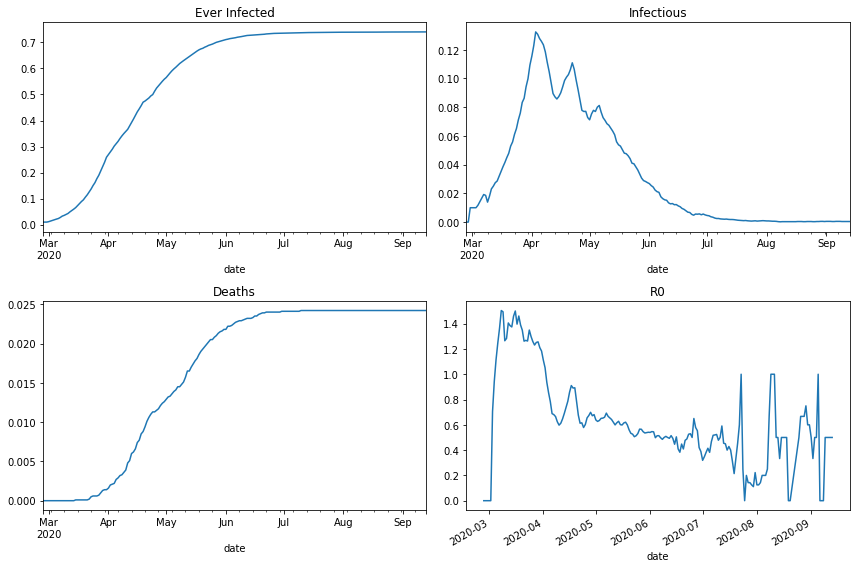

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

df.groupby("date").ever_infected.mean().plot(ax=axs[0])
df.groupby("date").infectious.mean().plot(ax=axs[1])
df.groupby("date").dead.mean().plot(ax=axs[2])

infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].groupby("date").infection_counter.mean().plot(ax=axs[3])

axs[0].set_title("Ever Infected")
axs[1].set_title("Infectious")
axs[2].set_title("Deaths")
axs[3].set_title("R0")

fig.tight_layout()